In [2]:
from __future__ import print_function, division
import random
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, models, transforms, utils
from IPython.display import clear_output, display
from sklearn.preprocessing import scale, MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [4]:
denom = 1
original_image_width = 768
original_image_height = 768
image_width = 224
image_height = 224

In [5]:
model = models.vgg16_bn(pretrained=True)

In [6]:
train_split = 0.8

In [7]:
def rle_decode(rle_image):
    image_array = np.zeros(original_image_height*original_image_width)
    for rle_tuple in rle_image:
        number_of_pixels = int(rle_tuple[1]) - 1
        pixel = int(rle_tuple[0])
        image_array[pixel:pixel + number_of_pixels] = 1
#         for i in range(number_of_pixels):
#             pixel = int(pixel)
#             image_array[pixel + i] = 1
    return np.reshape(image_array, (original_image_height, original_image_width), order='F')

In [8]:
ships_frame = pd.read_csv('data/train_ship_segmentations_v2.csv')

n = 5
img_name = ships_frame.iloc[n, 0]
ships = ships_frame.iloc[n, 1].split(' ')
print(ships)
ships = np.asarray(ships).reshape(-1, 2)
ships = rle_decode(ships)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(ships.shape))

['198320', '10', '199088', '10', '199856', '10', '200624', '10', '201392', '10', '202160', '10', '202928', '10', '203696', '10', '204464', '10', '205232', '10', '206000', '10', '206768', '10', '207536', '10', '208304', '10', '209072', '10', '209840', '10', '210608', '10', '211376', '10', '212144', '10', '212912', '10', '213680', '10', '214448', '10', '215216', '10', '215984', '10', '216751', '10', '217519', '10', '218287', '10', '219055', '10', '219823', '10', '220591', '10', '221359', '10', '222127', '10', '222895', '10', '223663', '10', '224431', '10', '225199', '10', '225967', '10', '226735', '10', '227503', '10', '228271', '10', '229039', '10', '229807', '10', '230575', '10', '231343', '10', '232111', '10', '232879', '10', '233647', '10', '234415', '10']
Image name: 000194a2d.jpg
Landmarks shape: (768, 768)


In [9]:
print(ships[:4])
print(rle_decode(ships[:4]).max())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0


000194a2d.jpg


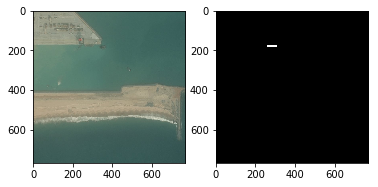

In [10]:
def show_ship_images(image, ships):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(ships, 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
print(img_name)
show_ship_images(io.imread(os.path.join('data/train_v2', img_name)),
               ships)
plt.show()

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, dimensions=None):
        self.dimensions = dimensions
        
    def __call__(self, sample):
        image, loc_image = sample['image'], sample['loc_image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        if self.dimensions:
            height, width = self.dimensions
            image = transform.resize(image, (height, width), anti_aliasing=True, preserve_range=True)
            loc_image = transform.resize(loc_image, (height, width), anti_aliasing=False, preserve_range=True)
            loc_image[loc_image < 255] = 0
            
        image = image.transpose((2, 0, 1)).astype(np.float32) / 255
        loc_image = loc_image.reshape(1, loc_image.shape[0], loc_image.shape[1]).astype(np.float32) / 255
        contains_ship = np.asarray([1, 0], dtype=np.float32) if np.count_nonzero(loc_image) == 0 else np.asarray([0,1],dtype=np.float32)
        return {'image': torch.from_numpy(image),
                'loc_image': torch.from_numpy(loc_image),
                'contains_ship': torch.from_numpy(contains_ship)}

In [12]:
class ShipData(Dataset):
    def __init__(self):
        self.ships_dataframe = pd.read_csv('data/train_ship_segmentations_v2.csv')

    def __len__(self):
        return len(self.ships_dataframe)
    
    def __getitem__(self, idx):
        image_name = self.ships_dataframe.iloc[idx, 0]
        image_path = 'data/train_v2/' + image_name
        image = io.imread(image_path)
        if pd.isnull(self.ships_dataframe.iloc[idx, 1]):
            ship_loc_data = []
        else:
            ship_loc_data = self.ships_dataframe.iloc[idx, 1]
            ship_loc_data = ship_loc_data.split(' ')
            ship_loc_data = np.asarray(ship_loc_data).reshape(-1, 2)
        
        loc_image = rle_decode(ship_loc_data)
        
        sample = {'image': image, 'loc_image': loc_image}
        return sample
                

class MergeShipData(Dataset):
    def __init__(self):
        self.ships_dataframe = pd.read_csv('data/train_ship_segmentations_v2.csv')
        self.merge_ships_dict = self._merge_ships(self.ships_dataframe)
        self.merge_ships_dataframe = self.ships_dataframe.drop('EncodedPixels', 1).drop_duplicates()
        self.transform = transforms.Compose([ToTensor((image_height, image_width))])

    def __len__(self):
        return len(self.merge_ships_dict) - 1
    
    def _get_blank_sample(self):
        image = np.zeros((image_height, image_width, 3))
        loc_image = rle_decode([])
        return {"image": image, "loc_image": loc_image, 'contains_ship': 0}
    
    def _get_image_mask(self, idx):
        image_name = self.ships_dataframe.iloc[idx, 0]
        if pd.isnull(self.ships_dataframe.iloc[idx, 1]):
            ship_loc_data = []
        else:
            ship_loc_data = self.ships_dataframe.iloc[idx, 1]
            ship_loc_data = ship_loc_data.split(' ')
            ship_loc_data = np.asarray(ship_loc_data).reshape(-1, 2)
        
        loc_image = rle_decode(ship_loc_data)
        return loc_image
        
    def __getitem__(self, idx):
        try:
            image_name = self.merge_ships_dataframe.iloc[idx, 0]
            image_idxs = self.merge_ships_dict[image_name]
            image_path = 'data/train_v2/' + image_name
            image = io.imread(image_path)
            loc_image = self._merge_images(image_idxs)
            sample = {'image': image, 'loc_image': loc_image }
        except:
            sample = self._get_blank_sample()
        return self.transform(sample)
    
    def _merge_ships(self, df):
        ships = {}
        for idx, row in df.iterrows():
            image_name = row[0]
            if image_name in ships:
                ships[image_name].append(idx)
            else:
                ships[image_name] = [idx]
        return ships
    
    def _merge_images(self, idxs):
        img = rle_decode([])
        for idx in idxs:
            img = np.logical_or(img, self._get_image_mask(idx)).astype(float)

        return img.astype(np.uint8) * 255
            
        

In [13]:
sd = MergeShipData()

In [14]:
len(sd)

192555

In [15]:
# last = 0
# for i in range(len(sd)):
#     last = i
#     print(i)
#     sd[i]
#     clear_output(wait=True)

In [16]:
sd[3]['loc_image']

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [17]:
def plot_sample(sample):
    toPilImage = transforms.ToPILImage()
    to1ChannelPilImage = transforms.ToPILImage()
    image = toPilImage(sample['image'])
    loc_image = to1ChannelPilImage(sample['loc_image'])
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(loc_image, 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
# number_to = 50
# number_from = 30
# for i in range(number_from, number_to):
#     plot_sample(sd[i])

In [19]:
def generate_train_and_test_idxs(dataset_length, train_split):
    np.random.seed(42)
    idxs = list(range(dataset_length))
    split = int(np.floor(train_split * dataset_length))
    np.random.shuffle(idxs)
    return idxs[:split], idxs[split:]

def get_train_and_test_datasets(dataset, max_length=None, batch_size=8):
    dataset_length = max_length or len(dataset)
    train_indices, val_indices = generate_train_and_test_idxs(dataset_length, train_split)
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=validation_sampler)
    return train_loader, validation_loader
    

In [20]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [21]:
# read https://arxiv.org/pdf/1505.04366.pdf
# perhaps combine with https://arxiv.org/pdf/1311.2524.pdf
class MaskModel(torch.nn.Module):
    def __init__(self, use_vgg=True):
        super(MaskModel, self).__init__()
        
        self.use_vgg = use_vgg
        
        
        # conv layers
        if not use_vgg:
            # 224x224
            vgg = models.vgg16_bn(pretrained=True)
            self.cnn1_1 = vgg.classifier[0] 
            self.cnn1_2 = torch.nn.Conv2d(64, 64, 3, padding=1)
            # 112x112
            self.cnn2_1 = torch.nn.Conv2d(64, 128, 3, padding=1) 
            self.cnn2_2 = torch.nn.Conv2d(128, 128, 3, padding=1) 
            # 56x56
            self.cnn3_1 = torch.nn.Conv2d(128, 256, 3, padding=1)
            self.cnn3_2 = torch.nn.Conv2d(256, 256, 3, padding=1)
            self.cnn3_3 = torch.nn.Conv2d(256, 256, 3, padding=1)
            # 28x28
            self.cnn4_1 = torch.nn.Conv2d(256, 512, 3, padding=1)
            self.cnn4_2 = torch.nn.Conv2d(512, 512, 3, padding=1)
            self.cnn4_3 = torch.nn.Conv2d(512, 512, 3, padding=1)
            # 14x14
            self.cnn5_1 = torch.nn.Conv2d(512, 512, 3, padding=1)
            self.cnn5_2 = torch.nn.Conv2d(512, 512, 3, padding=1)
            self.cnn5_3 = torch.nn.Conv2d(512, 512, 3,padding=1)
            
        else:
            self.vgg = models.vgg16_bn(pretrained=True)
            for param in self.vgg.features.parameters():
                param.require_grad = False
                
        # 7x7
        self.cnn6 = torch.nn.Conv2d(512, 4096, 7)
        # 1x1
        self.cnn7 = torch.nn.Conv2d(4096, 4096, 1)
        
        self.out_conv = torch.nn.Conv2d(64, 1, 1)
        
        # deconv layers
        # 7x7
        self.decnn6 = torch.nn.ConvTranspose2d(4096, 512, 7)
        
        # 14x14
        self.decnn5_1 = torch.nn.ConvTranspose2d(512, 512, 3, padding=1)
        self.decnn5_2 = torch.nn.ConvTranspose2d(512, 512, 3, padding=1)
        self.decnn5_3 = torch.nn.ConvTranspose2d(512, 512, 3, padding=1)
        
        # 28x28
        self.decnn4_1 = torch.nn.ConvTranspose2d(512, 512, 3, padding=1)
        self.decnn4_2 = torch.nn.ConvTranspose2d(512, 512, 3, padding=1)
        self.decnn4_3 = torch.nn.ConvTranspose2d(512, 256, 3, padding=1)
        
        # 56x56
        self.decnn3_1 = torch.nn.ConvTranspose2d(256, 256, 3, padding=1)
        self.decnn3_2 = torch.nn.ConvTranspose2d(256, 256, 3, padding=1)
        self.decnn3_3 = torch.nn.ConvTranspose2d(256, 128, 3, padding=1)
        
        # 112x112
        self.decnn2_1 = torch.nn.ConvTranspose2d(128, 128, 3, padding=1)
        self.decnn2_2 = torch.nn.ConvTranspose2d(128, 64, 3, padding=1)
        
        # 224x224
        self.decnn1_1 = torch.nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.decnn1_2 = torch.nn.ConvTranspose2d(64, 64, 3, padding=1)
        
        # pooling layers
        self.pool2d = torch.nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool2d = torch.nn.MaxUnpool2d(2, stride=2)
        
        # activation layers
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax2d()
        
        # other layers
        self.dropout = torch.nn.Dropout2d()
        self.batchnorm1_1 = torch.nn.BatchNorm2d(64)
        self.batchnorm1_2 = torch.nn.BatchNorm2d(64)
        self.batchnorm2_1 = torch.nn.BatchNorm2d(128)
        self.batchnorm2_2 = torch.nn.BatchNorm2d(128) 
        self.batchnorm3_1 = torch.nn.BatchNorm2d(256)
        self.batchnorm3_2 = torch.nn.BatchNorm2d(256)  
        self.batchnorm3_3 = torch.nn.BatchNorm2d(256)  
        self.batchnorm4_1 = torch.nn.BatchNorm2d(512)
        self.batchnorm4_2 = torch.nn.BatchNorm2d(512)
        self.batchnorm4_3 = torch.nn.BatchNorm2d(512) 
        self.batchnorm5_1 = torch.nn.BatchNorm2d(512)
        self.batchnorm5_2 = torch.nn.BatchNorm2d(512)
        self.batchnorm5_3 = torch.nn.BatchNorm2d(512)
        self.batchnorm6 = torch.nn.BatchNorm2d(4096)
        
        self.up_batchnorm6 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm5_1 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm5_2 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm5_3 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm4_1 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm4_2 = torch.nn.BatchNorm2d(512)
        self.up_batchnorm4_3 = torch.nn.BatchNorm2d(256)
        self.up_batchnorm3_1 = torch.nn.BatchNorm2d(256)
        self.up_batchnorm3_2 = torch.nn.BatchNorm2d(256)
        self.up_batchnorm3_3 = torch.nn.BatchNorm2d(128)
        self.up_batchnorm2_1 = torch.nn.BatchNorm2d(128)
        self.up_batchnorm2_2 = torch.nn.BatchNorm2d(64)
        self.up_batchnorm1_1 = torch.nn.BatchNorm2d(64)
        self.up_batchnorm1_2 = torch.nn.BatchNorm2d(64)

    def forward(self, x):
         
        if self.use_vgg:
            features = list(self.vgg.features.children())
            result = features[0](x)
            result = features[1](result)
            result = features[2](result)
            result = features[3](result)
            result = features[4](result)
            result = features[5](result)
            
            mpool = features[6]
            mpool.return_indices = True
            result, indices1 = mpool(result)

            result = features[7](result)
            result = features[8](result)
            result = features[9](result)
            result = features[10](result)
            result = features[11](result)
            result = features[12](result)
            
            mpool = features[13]
            mpool.return_indices = True
            result, indices2 = mpool(result)

            result = features[14](result)
            result = features[15](result)
            result = features[16](result)
            result = features[17](result)
            result = features[18](result)
            result = features[19](result)
            result = features[20](result)
            result = features[21](result)
            result = features[22](result)
            
            mpool = features[23]
            mpool.return_indices = True
            result, indices3 = mpool(result)

            result = features[24](result)
            result = features[25](result)
            result = features[26](result)
            result = features[27](result)
            result = features[28](result)
            result = features[29](result)
            result = features[30](result)
            result = features[31](result)
            result = features[32](result)
            
            mpool = features[33]
            mpool.return_indices = True
            result, indices4 = mpool(result)

            result = features[34](result)
            result = features[35](result)
            result = features[36](result)
            result = features[37](result)
            result = features[38](result)
            result = features[39](result)
            result = features[40](result)
            result = features[41](result)
            result = features[42](result)
            
            mpool = features[43]
            mpool.return_indices = True
            result, indices5 = mpool(result)
        else:
            result = self.cnn1_1(x)
            result = self.batchnorm1_1(result)
            result = self.relu(result)
            result = self.cnn1_2(result)
            result = self.batchnorm1_2(result)
            result = self.relu(result)
            result, indices1 = self.pool2d(result)

            result = self.cnn2_1(result)
            result = self.batchnorm2_1(result)
            result = self.relu(result)
            result = self.cnn2_2(result)
            result = self.batchnorm2_2(result)
            result = self.relu(result)
            result, indices2 = self.pool2d(result)

            result = self.cnn3_1(result)
            result = self.batchnorm3_1(result)
            result = self.relu(result)
            result = self.cnn3_2(result)
            result = self.batchnorm3_2(result)
            result = self.relu(result)
            result = self.cnn3_3(result)
            result = self.batchnorm3_3(result)
            result = self.relu(result)
            result, indices3 = self.pool2d(result)

            result = self.cnn4_1(result)
            result = self.batchnorm4_1(result)
            result = self.relu(result)
            result = self.cnn4_2(result)
            result = self.batchnorm4_2(result)
            result = self.relu(result)
            result = self.cnn4_3(result)
            result = self.batchnorm4_3(result)
            result = self.relu(result)
            result, indices4 = self.pool2d(result)

            result = self.cnn5_1(result)
            result = self.batchnorm5_1(result)
            result = self.relu(result)
            result = self.cnn5_2(result)
            result = self.batchnorm5_2(result)
            result = self.relu(result)
            result = self.cnn5_3(result)
            result = self.batchnorm5_3(result)
            result = self.relu(result)
            result, indices5 = self.pool2d(result)
     
            
        
        result = self.cnn6(result)
        result = self.batchnorm6(result)
        result = self.relu(result)
        
        result = self.decnn6(result)
        result = self.up_batchnorm6(result)
        result = self.relu(result)
        
        result = self.unpool2d(result, indices5)
        
        result = self.decnn5_1(result)
        result = self.up_batchnorm5_1(result)
        result = self.relu(result)
        result = self.decnn5_2(result)
        result = self.up_batchnorm5_2(result)
        result = self.relu(result)
        result = self.decnn5_3(result)
        result = self.up_batchnorm5_3(result)
        result = self.relu(result)
        
        result = self.unpool2d(result, indices4)
        
        result = self.decnn4_1(result)
        result = self.up_batchnorm4_1(result)
        result = self.relu(result)
        result = self.decnn4_2(result)
        result = self.up_batchnorm4_2(result)
        result = self.relu(result)
        result = self.decnn4_3(result)
        result = self.up_batchnorm4_3(result)
        result = self.relu(result)
        
        result = self.unpool2d(result, indices3)
                           
        result = self.decnn3_1(result)
        result = self.up_batchnorm3_1(result)
        result = self.relu(result)
        result = self.decnn3_2(result)
        result = self.up_batchnorm3_2(result)
        result = self.relu(result)
        result = self.decnn3_3(result)
        result = self.up_batchnorm3_3(result)
        result = self.relu(result)
        
        result = self.unpool2d(result, indices2)

        result = self.decnn2_1(result)
        result = self.up_batchnorm2_1(result)
        result = self.relu(result)
        result = self.decnn2_2(result)
        result = self.up_batchnorm2_2(result)
        result = self.relu(result)
        
        result = self.unpool2d(result, indices1)
        
        result = self.decnn1_1(result)
        result = self.up_batchnorm1_1(result)
        result = self.relu(result)
        result = self.decnn1_2(result)
        result = self.up_batchnorm1_2(result)
        result = self.relu(result)
        result = self.out_conv(result)
        #result = self.softmax(result)
        result = self.sigmoid(result)
        return result
    
    

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
model = MaskModel()

In [24]:
model = model.to(device)

In [25]:
optimizer = torch.optim.Adam(model.parameters())
#criterion = torch.nn.CrossEntropyLoss(torch.tensor([0.1, 0.9]).to(device))
criterion = torch.nn.MSELoss()

In [26]:
loss_history = list()

In [27]:
train_loader, validation_loader = get_train_and_test_datasets(sd, max_length=None, batch_size=6)

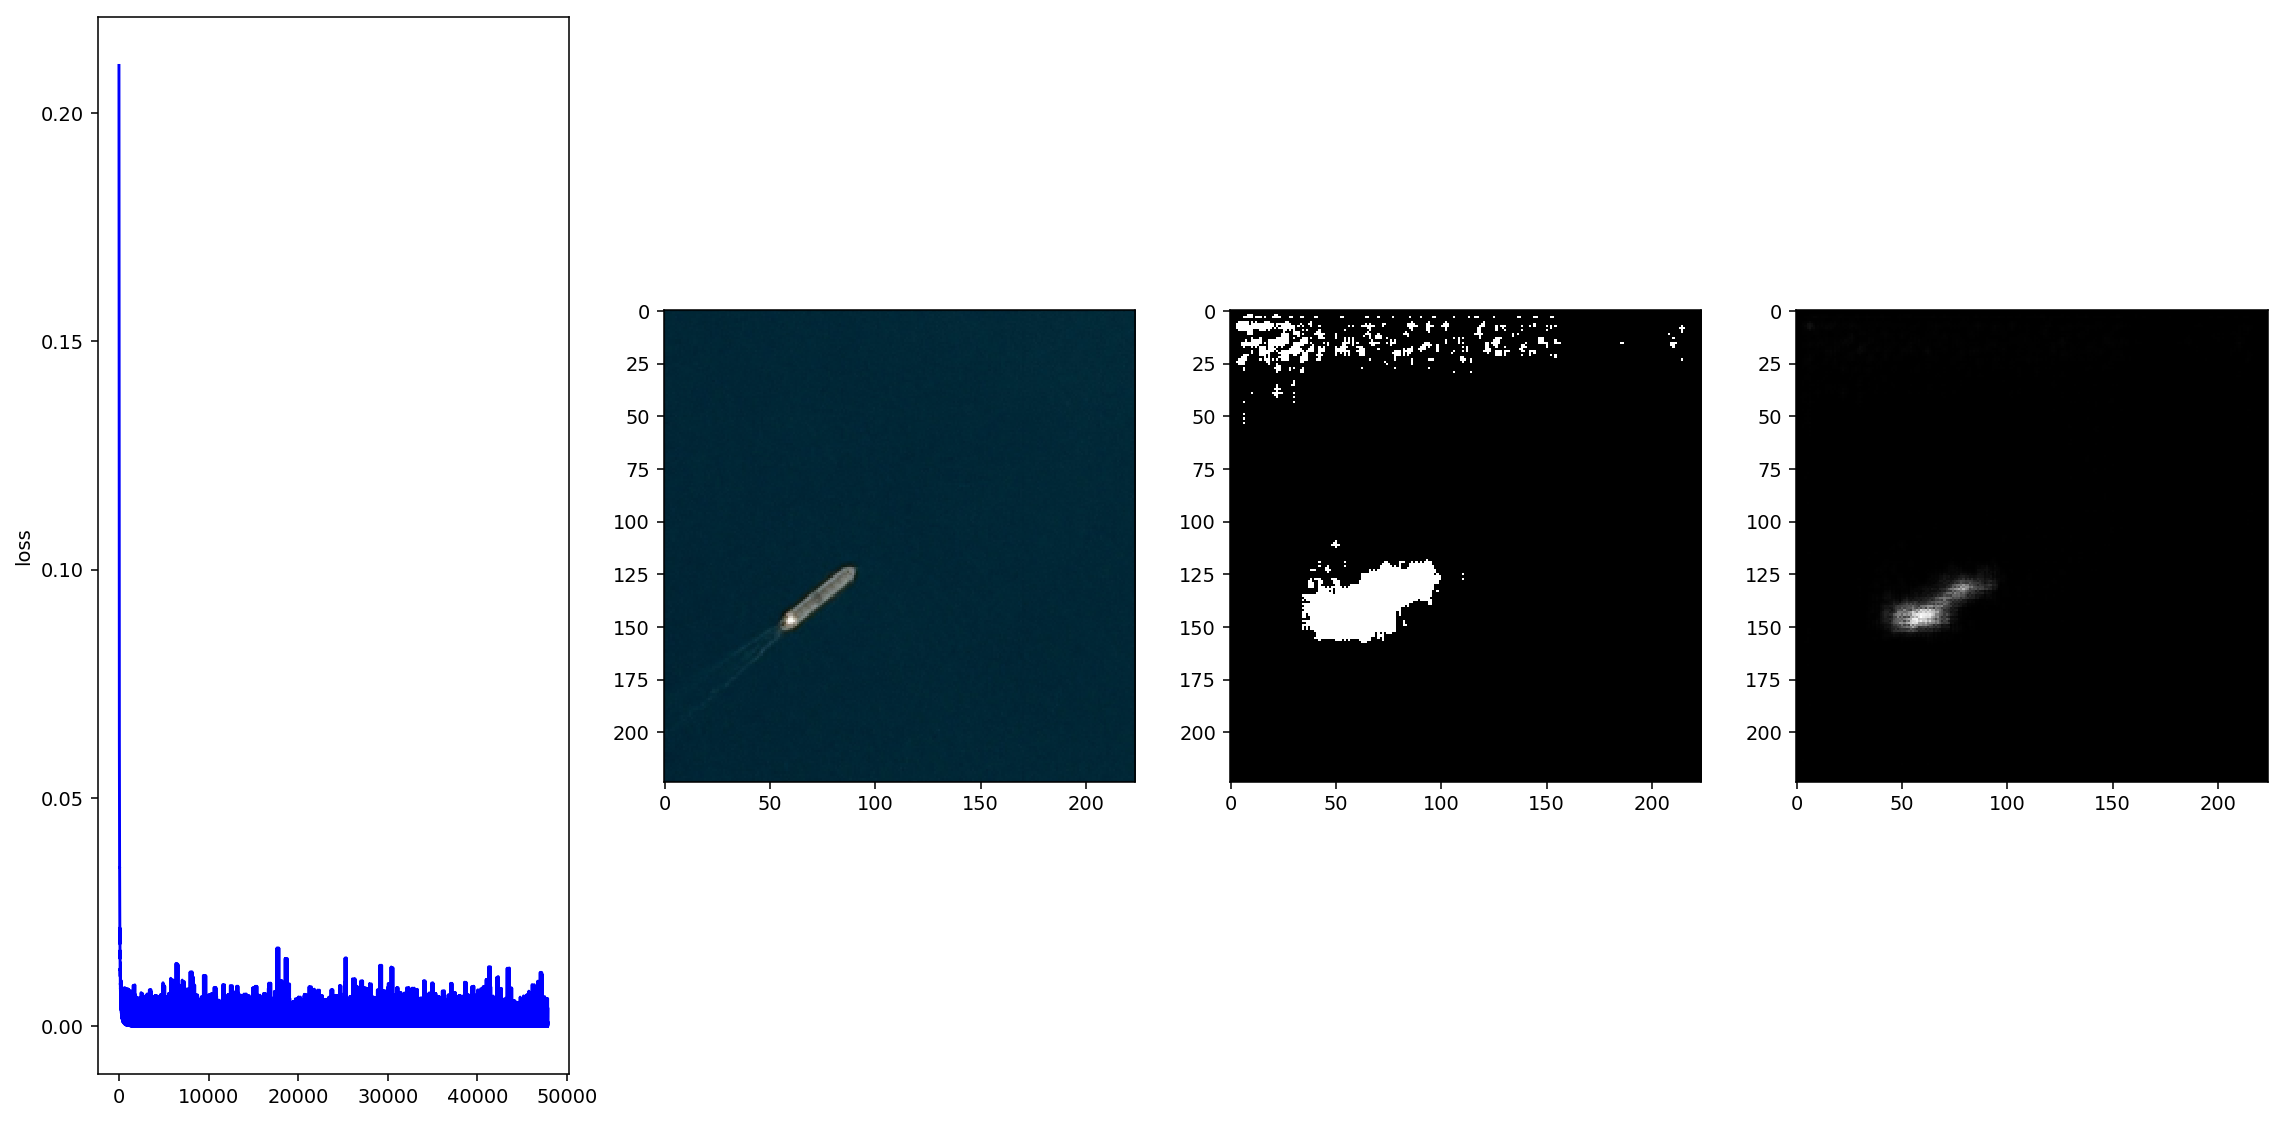

loss: 0.000646355387289077
batch: 15957
epoch: 0
repeat: 2
sample index: 100


In [ ]:
num_epochs = 1
model.train()
toPilImage = transforms.ToPILImage()
data_size_to_repeat = 100
sample_buffer = list()
number_of_repeats = 3
test_image = image = sd[50]['image']
for epoch in range(num_epochs):
    # Train:   
    for batch_index, sample in enumerate(train_loader):
        sample_buffer.append(sample)
        if len(sample_buffer) > data_size_to_repeat:
            for i in range(number_of_repeats):
                random.shuffle(sample_buffer)
                for sample_index, sample in enumerate(sample_buffer):
                    model.train()
                    image = sample['image'].to(device)
                    labels = sample['loc_image'].to(device)
                    outputs = model(image)
                    loss = criterion(outputs, labels)
                    loss_history.append(loss.item())

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
        
                plt.figure(num=None, figsize=(20, 10), dpi=140, facecolor='w', edgecolor='k')
                plt.subplot(141)
                plt.plot(loss_history, color='blue')
                plt.ylabel('loss')
                #plt.show()
                #plt.plot(loss_history[len(loss_history) - 24:])
                #plt.ylabel('loss in last 24 batches')


                model.eval()
                image = test_image.to(device)
                plt.subplot(142)
                plt.imshow(toPilImage(test_image))
                plt.subplot(143)
                output = model(torch.unsqueeze(image, 0))[0].cpu().data
                scaled_output = (output - output.min())
                scaled_output = scaled_output / scaled_output.max()
                threshold = output.mean()
                #output = (output * (255/(output.max())))
                output[output > threshold] = 1.0
                output[output <= threshold ] = 0.0

                plt.imshow(toPilImage(output))
                plt.subplot(144)
                plt.imshow(toPilImage(scaled_output))
        #         output = model(torch.unsqueeze(image, 0))[0].cpu().data[1:2]
        #         plt.imshow(toPilImage((output * (255/(output.max())))))
                plt.show()
                model.train()
                print(f'loss: {loss.item()}\nbatch: {batch_index}\nepoch: {epoch}\nrepeat: {i}\nsample index: {sample_index}')
                #print(labels.cpu().long().unique())
                clear_output(wait=True)
            sample_buffer = list()
       

In [ ]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for index, sample in enumerate(validation_loader):
        image = sample['image'].to(device)
        labels = sample['contains_ship'].to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu().data.numpy().astype(np.float32) == labels[:,0]).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [46]:
toPilImage = transforms.ToPILImage()
device = torch.device('cpu')
model = model.to(device)
model.eval()
image = sd[50]['image'].to(device)
output = model(torch.unsqueeze(image, 0))[0]

In [47]:
output[0:1].shape

torch.Size([1, 224, 224])

In [48]:
torch.max(output, 1)
#print(argmax)

#torch.gather(output, 1, argmax)

(tensor([[6.9642e-01, 7.9341e-08, 1.5378e-05, 2.5854e-02, 2.5139e-01, 6.9642e-01,
          6.9642e-01, 2.7302e-01, 2.1686e-01, 2.7278e-01, 3.3967e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 5.4391e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 5.2545e-01, 4.2955e-01, 5.8759e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 3.1641e-01, 3.8166e-01, 2.5776e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 3.8925e-01, 4.9770e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 4.4466e-01, 3.8727e-01, 6.9642e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01,
          6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01, 6.9642e-01,
          2.6549e-01, 3.1488e-01, 3.3890e-01, 4.1281e-01, 6.9642e-01, 6.9642e-01,
          6.9642

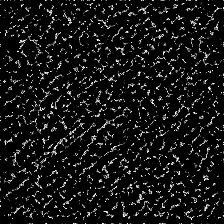

In [49]:
toPilImage((output[0:1] * (255/(output[0:1].max()))))

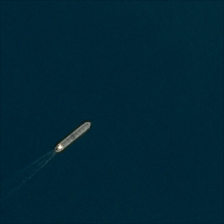

In [50]:
toPilImage(image)

In [51]:
def infer_and_compare_result(model, sample):
    model.eval()
    image = sample['image'].to(device)
    label = sample['loc_image'].to(device)
    output = model(torch.unsqueeze(image, 0))[0]
    
    
    toPilImage = transforms.ToPILImage()
    image = toPilImage(sample['image'])
    loc_image = toPilImage(sample['loc_image'])
    output_image = toPilImage((output * 255/output.max()))
    plt.figure(num=None, figsize=(32, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(loc_image, 'gray')
    plt.subplot(1,3,3)
    plt.imshow(output_image, 'gray')
    
    plt.pause(0.001)  # pause a bit so that plots are updated

tensor(1.)


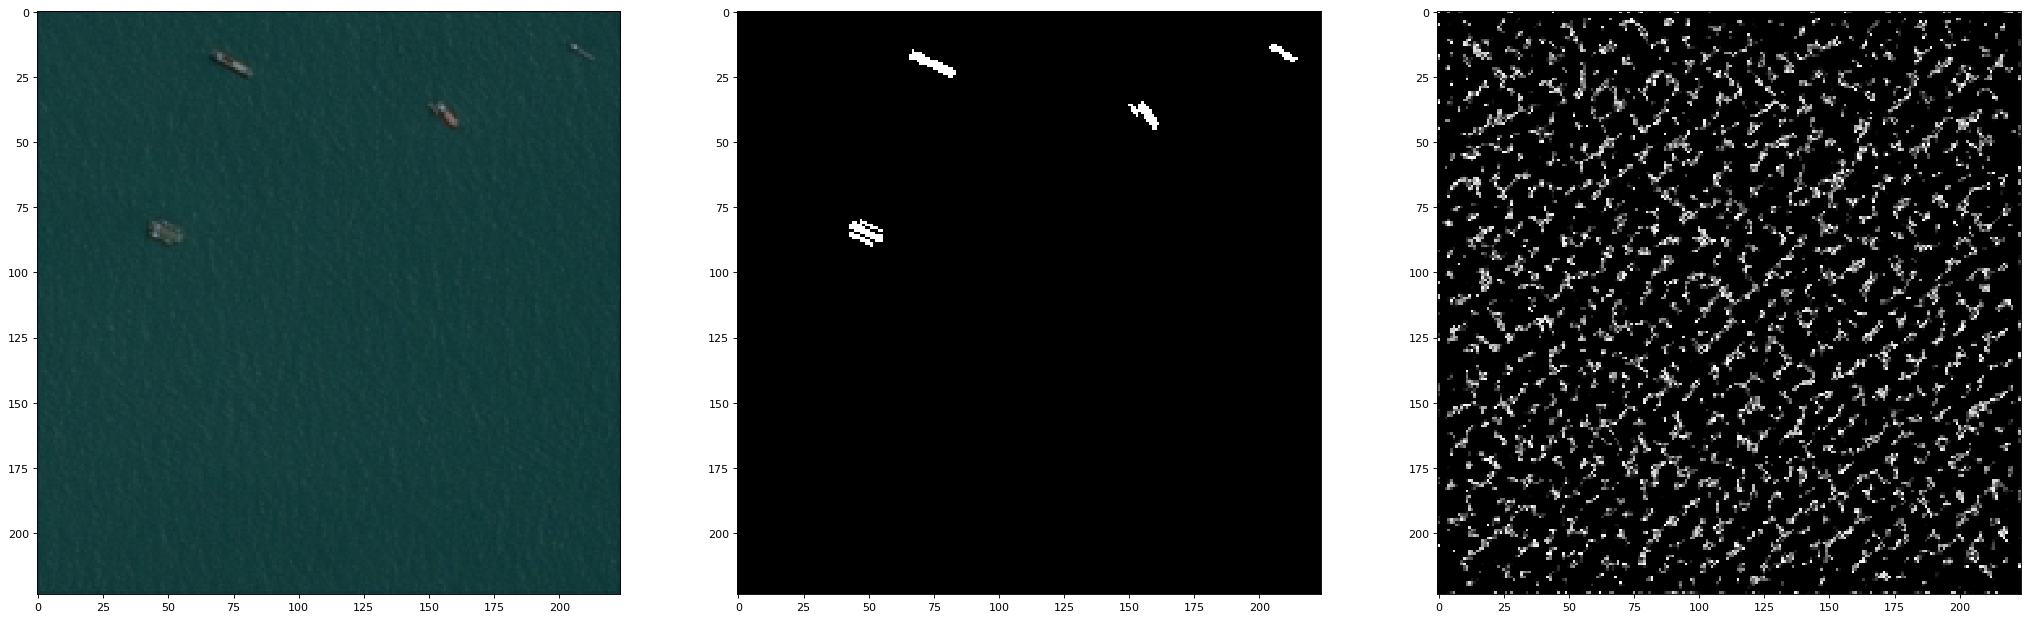

In [52]:
print(sd[50]['loc_image'].max())
infer_and_compare_result(model, sd[45])

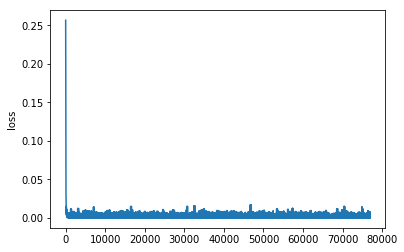

In [53]:
plt.plot(loss_history)
plt.ylabel('loss')
plt.show()

torch.Size([1, 124, 124])


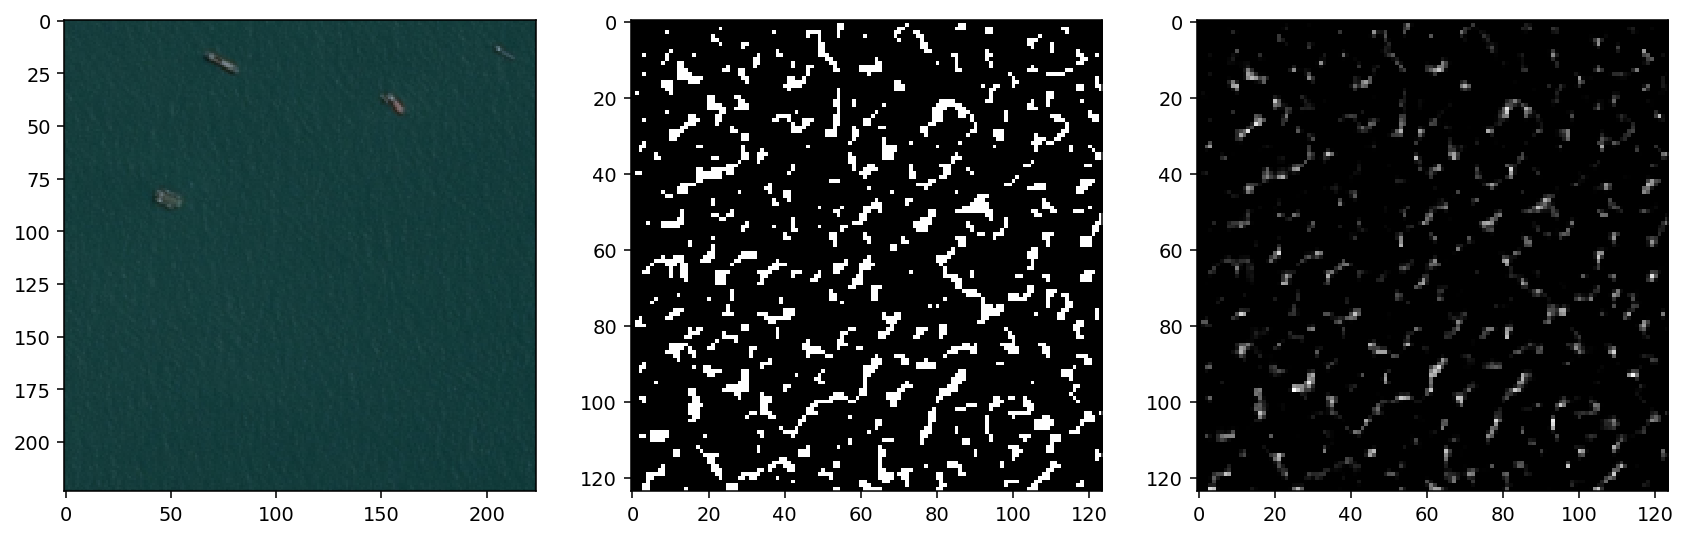

In [54]:
model.eval()
plt.figure(num=None, figsize=(20, 10), dpi=140, facecolor='w', edgecolor='k')
image = sd[45]['image']
plt.subplot(142)
plt.imshow(toPilImage(image))
image = image.to(device)
plt.subplot(143)
output = model(torch.unsqueeze(image, 0))[0, 0:1, 2:126, 2:126].cpu().data
print(output.shape)
scaled_output = (output - output.min())
scaled_output = scaled_output / scaled_output.max()
threshold = output.mean()
#output = (output * (255/(output.max())))
output[output > threshold] = 1.0
output[output <= threshold ] = 0.0

plt.imshow(toPilImage(output))
plt.subplot(144)
plt.imshow(toPilImage(scaled_output))
#         output = model(torch.unsqueeze(image, 0))[0].cpu().data[1:2]
#         plt.imshow(toPilImage((output * (255/(output.max())))))
plt.show()